Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB
None

Missing Values:
age                    0
sex                    0
chest pain type        0
resting bp s           0
chol

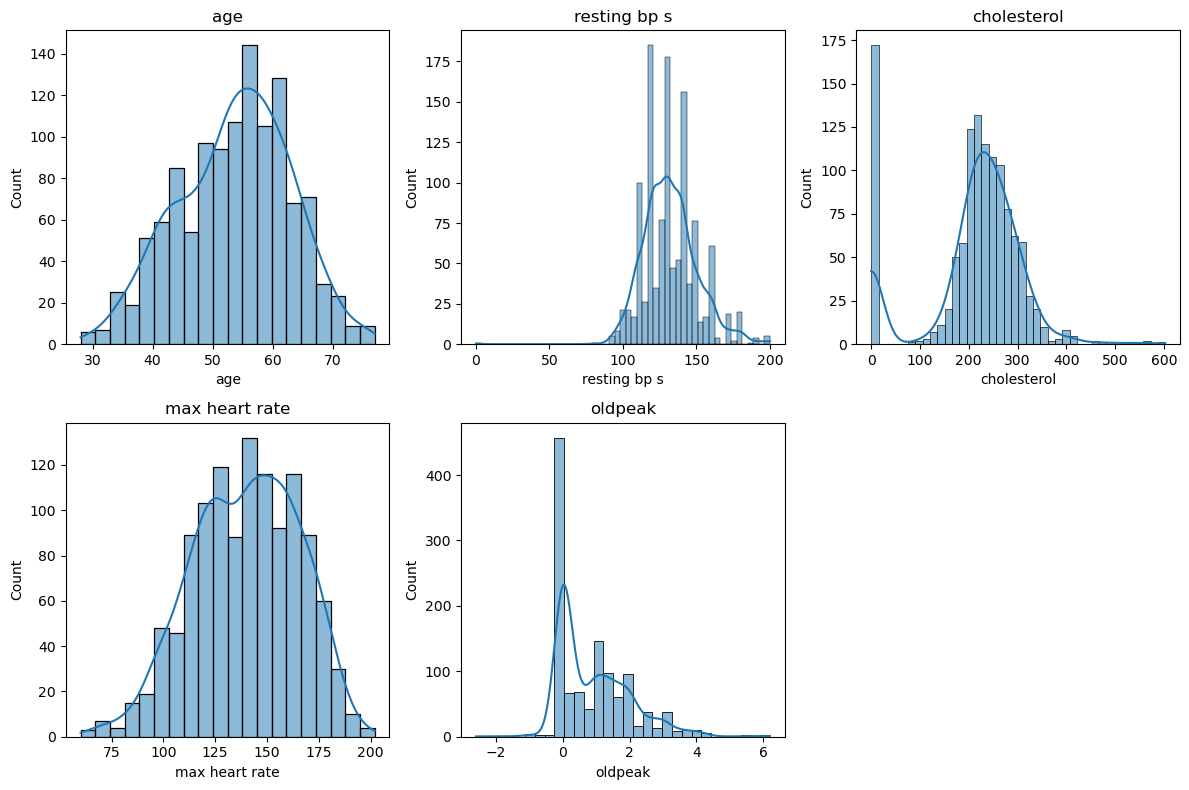


Rows with cholesterol = 0: 172

Cross-Validation Results:
Accuracy (mean ± std): 0.895 ± 0.016
Precision (mean ± std): 0.888 ± 0.026
Recall (mean ± std): 0.918 ± 0.017
Roc_auc (mean ± std): 0.944 ± 0.018

Test Set Performance:
Accuracy: 0.924
Precision: 0.958
Recall: 0.897
ROC-AUC: 0.926


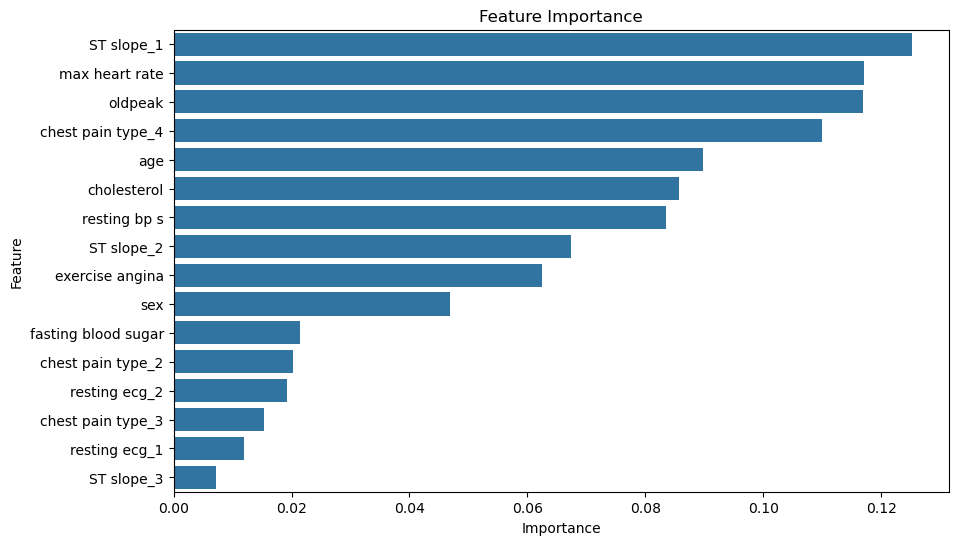

['scaler.pkl']

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('dataset.csv')

# 1. Data Exploration
print("Dataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())
print("\nTarget Class Distribution:")
print(data['target'].value_counts(normalize=True))

# Visualize numeric feature distributions
numeric_cols = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Check for zero cholesterol values (potential data issues)
print("\nRows with cholesterol = 0:", (data['cholesterol'] == 0).sum())

# 2. Preprocessing
# Replace cholesterol = 0 with median (considering it as a data error)
data.loc[data['cholesterol'] == 0, 'cholesterol'] = data['cholesterol'].median()

# Define feature types
nominal_cols = ['chest pain type', 'resting ecg', 'ST slope']
binary_cols = ['sex', 'fasting blood sugar', 'exercise angina']
numeric_cols = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']

# One-hot encode nominal features
data_encoded = pd.get_dummies(data, columns=nominal_cols, drop_first=True)

# Split features and target
X = data_encoded.drop('target', axis=1)
y = data_encoded['target']

# Scale numeric features
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Modeling
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation
scoring = ['accuracy', 'precision', 'recall', 'roc_auc']
cv_results = cross_validate(rf_model, X_train, y_train, cv=5, scoring=scoring)

print("\nCross-Validation Results:")
for metric in scoring:
    print(f"{metric.capitalize()} (mean ± std): {cv_results[f'test_{metric}'].mean():.3f} ± {cv_results[f'test_{metric}'].std():.3f}")

# Train final model and evaluate on test set
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.3f}")

# 4. Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

# Save the model and scaler for future use
import joblib
joblib.dump(rf_model, 'heart_disease_model.pkl')
joblib.dump(scaler, 'scaler.pkl')